In [21]:
# import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import random
from statsmodels.tsa.stattools import acf
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from collections import Counter
import tensorflow as tf
from scipy.fft import fft
from scipy.signal import get_window
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from tensorflow.keras.models import Sequential
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import TimeSeriesSplit

import optuna
import warnings
warnings.filterwarnings('ignore')

In [22]:
# fetch "healthy data" and "anomalies" datasets and read them
healthy_data = pd.read_hdf("/content/drive/MyDrive/dataset/healthy_data.h5")
anomalies = pd.read_hdf("/content/drive/MyDrive/dataset/anomalies.h5")

In [23]:
# create a new column "label"
# label the "healthy data" data as "0" for normal and "anomalies" data as "1" for abnormal
healthy_data['label'] = 0
anomalies['label'] = 1

In [24]:
# combine both "healthy data" and "anomalies" datasets into one dataframe
data = pd.concat([healthy_data, anomalies], axis=0).reset_index(drop=True)


# randomly shuffle the rows to have a mixed rows of "healthy data" and "anomalies" sampl
data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

# check the shuffled DataFrame
print(data_shuffled.head())


          0         1         2         3         4         5         6  \
0 -1.080207 -0.788637 -0.837053 -1.160900 -1.391143 -1.106029 -0.324923   
1 -1.276654 -1.533189 -0.864752 -0.091534 -0.128870 -1.003257 -1.796951   
2  0.630677  0.605010  0.477897  0.155225 -0.441229 -0.679566 -0.515786   
3 -1.050008 -0.357603  0.730805  1.257609  1.360810  1.924814  2.548819   
4  0.311588  0.446899 -0.028552 -0.455588 -0.260691  0.120414  0.117932   

          7         8         9  ...     61431     61432     61433     61434  \
0  0.431437  0.714400  0.790789  ... -0.798320 -0.714400 -0.383022 -0.671364   
1 -1.947499 -1.831878 -1.817425  ... -1.723483 -1.466948 -0.693729 -0.090329   
2 -0.424118 -0.183336  0.394784  ... -0.041556 -0.176003 -0.301894 -0.177225   
3  2.402418  1.705213  0.708005  ...  0.307202  1.579212  2.134816  2.098816   
4  0.009931  0.158897  0.204829  ...  0.115449 -0.064552 -0.266898 -0.137794   

      61435     61436     61437     61438     61439  label  
0 -1.15

In [ ]:
# checking the labels count for imbalance
# observation: there is a class imbalance
data_shuffled.label.value_counts()

,count
label,
0,1677
1,594


In [ ]:
# descriptive analysis
data_shuffled.describe()

,0,1,2,3,4,5,6,7,8,9,...,61431,61432,61433,61434,61435,61436,61437,61438,61439,label
count,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,...,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000
mean,-0.887309,-0.897999,-0.904744,-0.900442,-0.882313,-0.862772,-0.848597,-0.844531,-0.852953,-0.866084,...,-0.915244,-0.913903,-0.933052,-0.966515,-0.974057,-0.955008,-0.931182,-0.911361,-0.907988,0.261559
std,4.562957,4.562100,4.604539,4.631536,4.605160,4.573192,4.571592,4.584429,4.587782,4.576549,...,4.628884,4.619053,4.626471,4.660177,4.686485,4.671811,4.640969,4.634546,4.639935,0.439580
min,-32.771890,-32.796411,-32.785377,-32.798863,-32.806220,-32.808672,-32.806220,-32.790281,-32.776794,-32.778020,...,-32.808672,-32.784150,-32.768211,-32.774342,-32.787829,-32.793959,-32.786603,-32.781698,-32.779246,0.000000
25%,-0.439003,-0.395214,-0.395770,-0.388287,-0.352335,-0.319195,-0.354310,-0.358119,-0.373420,-0.385074,...,-0.408734,-0.417183,-0.429237,-0.457936,-0.409750,-0.401726,-0.393590,-0.399003,-0.410617,0.000000
50%,-0.018592,-0.020977,-0.012222,0.000000,0.001220,0.003907,-0.003435,0.000000,0.000000,-0.006899,...,-0.011191,-0.016550,-0.023073,-0.025987,-0.021857,-0.014080,-0.016139,-0.020645,-0.020611,0.000000
75%,0.192001,0.205882,0.227916,0.274878,0.242955,0.269833,0.259603,0.266705,0.236817,0.231820,...,0.214111,0.200513,0.203283,0.196206,0.198609,0.218006,0.225065,0.213671,0.209868,1.000000
max,11.196882,11.198126,11.198126,11.198126,11.198126,11.198126,11.196882,11.196882,11.198126,11.199371,...,9.716076,9.716076,9.716076,9.716076,10.300524,9.716076,9.714832,9.714832,9.847754,1.000000


In [ ]:
# check for NaN or Null values
data_shuffled.loc[data_shuffled.isnull().any(axis=1), data_shuffled.isnull().any()]

""


In [25]:
labels = data_shuffled["label"].values  # Extract labels
features = data_shuffled.drop(columns=["label"])  # Drop the label column from data to have features

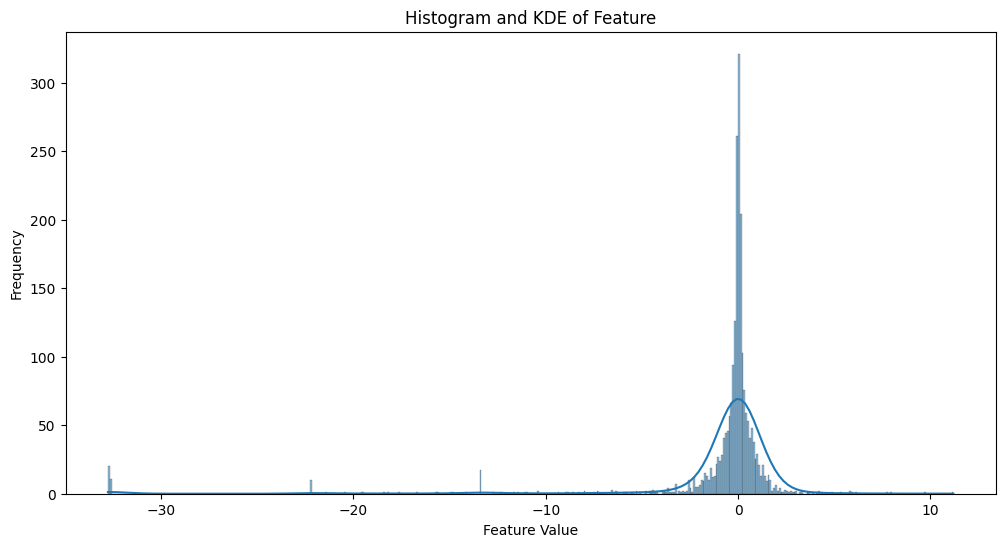

In [ ]:
# distribution analysis
# histogram of features df to visualize the distribution
plt.figure(figsize=(12, 6))
sns.histplot(features.iloc[:, 200], kde=True)
plt.title('Histogram and KDE of Feature')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.show()


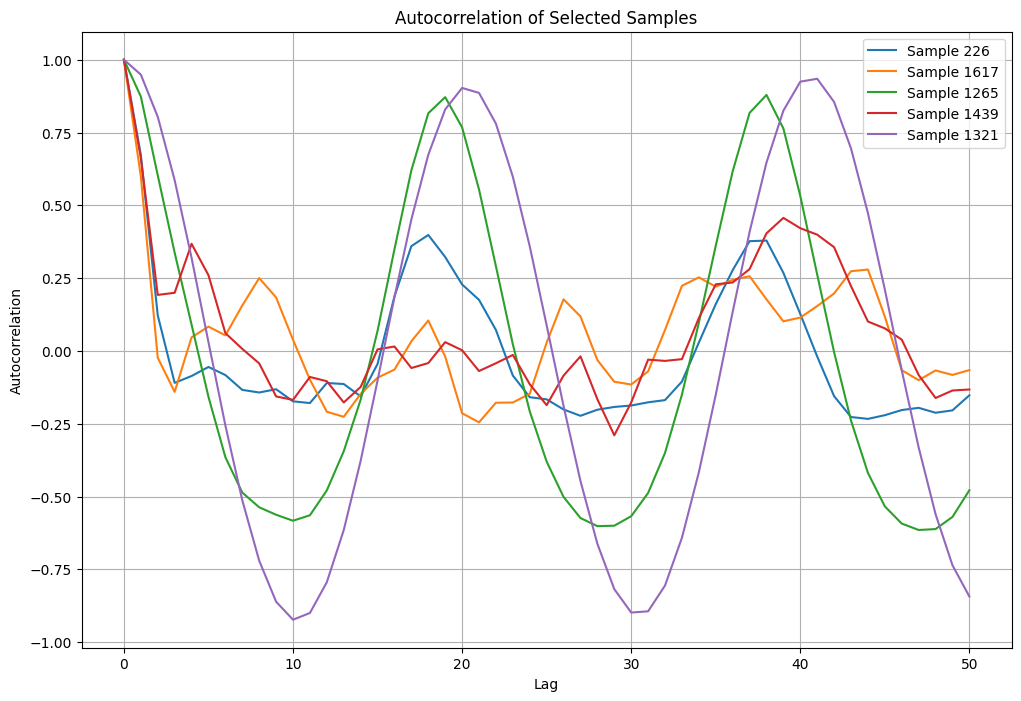

In [27]:
# autocorrelation analysis

# Number of lags to analyze
lags = 50

# select a few sequences randomly
sequences_to_analyze = random.sample(range(features.shape[0]), 5)


# plot the autocorrelation for selected sequences
plt.figure(figsize=(12, 8))

for idx in sequences_to_analyze:
    sequence_data = features.iloc[idx]  # get the samples (row) at index `idx`

    # compute autocorrelation for the sample
    autocorr_values = acf(sequence_data, nlags=lags)

    # plot the autocorrelation values
    plt.plot(range(lags + 1), autocorr_values, label=f'Sample {idx}')

# plot customization
plt.title('Autocorrelation of Selected Samples')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Implement a random seed to have random reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# split the dataset into train set, valid set, and test set
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.4, random_state=42, stratify=labels)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_valid.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (1362, 61440)
Validation data shape: (454, 61440)
Testing data shape: (455, 61440)


In [ ]:
# oversample the train set to address the class imbalance problem.
# only train set is resampled for balancing the class in order to keep the valid set as the same because this allows to test the model on real-world scenerio.
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# normalize the train set to standardize the feature values in the range [0,1].
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_resampled)

In [ ]:
# normalize both valid and test set.
X_valid_normalized = scaler.transform(X_valid)
X_test_normalized = scaler.transform(X_test)

In [ ]:
# perform Fast Fourier transformation (fft) to the data using sliding windows with windowing functions.
def fft_transformation_sliding_window(data, window_size, overlap, sampling_rate):
    """
    Parameters:
    - data: 2D numpy array of shape (num_sequences, num_samples)
      This is the input data, where each row represents a time-series signal for one sequence.
    - window_size: int, the size of the sliding window
      Defines the number of samples in each window for FFT computation, impacting frequency resolution.
    - overlap: int, the number of overlapping samples
      Determines how much overlap exists between consecutive windows. Higher overlap provides finer temporal resolution.
    - sampling_rate: int, the sampling rate in Hz
      Represents the frequency at which the acceleration data was sampled, which is required to interpret the FFT results.

    Returns:
    - fft_results: 3D numpy array of shape (num_sequences, num_windows, num_frequency_bins)
      FFT magnitudes computed for each window in each sequence, where `num_windows` is the number of windows derived from `window_size` and `overlap`.
    - freqs: 1D numpy array of frequency bins
      Array of frequency values corresponding to the FFT output, in Hz.

    """
    step = window_size - overlap
    num_windows = (data.shape[1] - window_size) // step + 1

    # prepare to store FFT results
    fft_results = []

    for sequence in data:
        sequence_fft = []
        for start in range(0, len(sequence) - window_size + 1, step):
            window = sequence[start:start + window_size]
            windowed_signal = window * get_window('hann', window_size)  # perform a Hann window
            fft_values = np.fft.rfft(windowed_signal)  # compute FFT
            fft_magnitude = np.abs(fft_values)  # get magnitude
            sequence_fft.append(fft_magnitude)

        fft_results.append(sequence_fft)

    # convert the results to a numpy array
    fft_results = np.array(fft_results)

    # Cclculate frequency bins
    num_frequency_bins = fft_results.shape[2]
    freqs = np.fft.rfftfreq(window_size, d=1/sampling_rate)

    return fft_results, freqs

sampling_rate = 1024  # Hz
window_size = 1024    # size of the window
overlap = 512         # overlap between windows

# perform FFT on the normalized datasets with sliding windows
X_train_fft, train_freqs = fft_transformation_sliding_window(X_train_normalized, window_size, overlap, sampling_rate)
X_valid_fft, valid_freqs = fft_transformation_sliding_window(X_valid_normalized, window_size, overlap, sampling_rate)
X_test_fft, test_freqs = fft_transformation_sliding_window(X_test_normalized, window_size, overlap, sampling_rate)

print("Training FFT data shape:", X_train_fft.shape)
print("Validation FFT data shape:", X_valid_fft.shape)
print("Testing FFT data shape:", X_test_fft.shape)

Training FFT data shape: (2012, 119, 513)
Validation FFT data shape: (454, 119, 513)
Testing FFT data shape: (455, 119, 513)


In [ ]:
# calculate class weights to handle class imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
# create a model with CNN+LSTM architecture to
def create_cnn_lstm_model(conv_filters, kernel_size, num_units_1, dense_units_1, dropout_rate, input_shape, l2_reg, learning_rate):
   """
    Create a CNN-LSTM model for sequence data classification.

    Parameters:
    - conv_filters (int): Number of filters in the convolutional layers.
    - kernel_size (int): Size of the convolutional kernel.
    - num_units_1 (int): Number of units in the LSTM layer.
    - dense_units_1 (int): Number of units in the dense layer after LSTM.
    - dropout_rate (float): Dropout rate to prevent overfitting.
    - input_shape (tuple): Shape of the input data (sequence length, number of features).
    - l2_reg (float): L2 regularization factor to reduce model complexity.
    - learning_rate (float): Learning rate for the Adam optimizer.

    Returns:
    - model (Sequential): Compiled CNN-LSTM model.
    """

    model = Sequential()

    # 1D convolutional layer
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))

    # second Conv1D layer for deeper feature extraction
    model.add(Conv1D(filters=conv_filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))

    # LSTM layer
    model.add(LSTM(num_units_1, kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(dense_units_1, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    # optimize the learning rate
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
def objective(trial):

    """
    Objective function for Optuna hyperparameter optimization.

    This function defines the model's architecture and training parameters for
    a CNN-LSTM binary classification task. Using Optuna, it samples hyperparameters
    from specified ranges and evaluates model performance on a validation set.

    Parameters:
    - trial: An Optuna trial object, which suggests values for each hyperparameter
      within specified ranges.

    Hyperparameters Sampled:
    - conv_filters (int): Number of convolutional filters in the 1D convolution layers,
      sampled from the range [32, 128] in steps of 16.
    - kernel_size (int): Size of the convolution kernel, sampled from [1, min(X_train.shape[1], 5)].
    - dense_units_1 (int): Number of units in the first dense layer, sampled from [32, 64] in steps of 16.
    - num_units_1 (int): Number of units in the LSTM layer, sampled from [16, 64] in steps of 16.
    - dropout_rate (float): Dropout rate for regularization, sampled from a range between 0.3 and 0.5.
    - l2_reg (float): L2 regularization factor, sampled logarithmically from [1e-6, 1e-2].
    - learning_rate (float): Learning rate for the Adam optimizer, sampled logarithmically
      from [1e-5, 1e-2].

    Training Configuration:
    - Early stopping is used to prevent overfitting, with `patience` set to 10 and
      `restore_best_weights` enabled.
    - The model is trained for a maximum of 100 epochs with a batch size of 64.
    - Class weights (computed externally) are used to handle class imbalance.

    Returns:
    - f1 (float): The F1 score calculated on the validation set, which is used
      by Optuna to determine the best hyperparameter configuration.

    """

    # hyperparameters
    conv_filters = trial.suggest_int('conv_filters', 32, 128, step=16)
    kernel_size = trial.suggest_int('kernel_size', 1, min(X_train.shape[1], 5))
    dense_units_1 = trial.suggest_int('dense_units_1', 32, 64, step=16)
    num_units_1 = trial.suggest_int('num_units_1', 16, 64, step=16)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.5)
    l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-2)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Create the model
    input_shape = (X_train_fft.shape[1], X_train_fft.shape[2])
    model = create_cnn_lstm_model(conv_filters, kernel_size, num_units_1, dense_units_1, dropout_rate, input_shape, l2_reg, learning_rate)

    # Fit the model
    history = model.fit(X_train_fft, y_train_resampled,
                        validation_data=(X_valid_fft, y_valid),
                        epochs=100,
                        batch_size=64,
                        class_weight=class_weights_dict,
                        verbose=0,
                        callbacks=[early_stopping])

    predict = model.predict(X_valid_fft)

    # Calculate the f1-score
    f1 = f1_score(y_valid, np.round(predict))

    # Return the f1-score
    return f1

# Step 1: Create a study object
study = optuna.create_study(direction='maximize')
# Step 2: Optimize hyperparameters
study.optimize(objective, n_trials=30)

# Output the best hyperparameters
print("Best hyperparameters: ", study.best_params)
print("Best validation f1-score: ", study.best_value)

[I 2024-11-06 12:50:35,524] A new study created in memory with name: no-name-5629b8ae-08c3-4f5e-a389-4904f9c2e141


15/15 [==============================] - 1s 10ms/step


[I 2024-11-06 12:51:43,371] Trial 0 finished with value: 0.7741935483870968 and parameters: {'conv_filters': 80, 'kernel_size': 2, 'dense_units_1': 64, 'num_units_1': 48, 'dropout_rate': 0.3570637187940089, 'l2_reg': 0.00011704061327418417, 'learning_rate': 0.004178587678641758}. Best is trial 0 with value: 0.7741935483870968.


15/15 [==============================] - 1s 8ms/step


[I 2024-11-06 12:53:14,198] Trial 1 finished with value: 0.8559322033898306 and parameters: {'conv_filters': 128, 'kernel_size': 1, 'dense_units_1': 48, 'num_units_1': 16, 'dropout_rate': 0.34148705824503556, 'l2_reg': 0.00041032142905996513, 'learning_rate': 0.00046029250051495555}. Best is trial 1 with value: 0.8559322033898306.


15/15 [==============================] - 1s 9ms/step


[I 2024-11-06 12:54:00,003] Trial 2 finished with value: 0.7439613526570048 and parameters: {'conv_filters': 32, 'kernel_size': 3, 'dense_units_1': 32, 'num_units_1': 64, 'dropout_rate': 0.40744335083256034, 'l2_reg': 0.0068879206132742, 'learning_rate': 0.0017778605792721095}. Best is trial 1 with value: 0.8559322033898306.


15/15 [==============================] - 1s 7ms/step


[I 2024-11-06 12:54:59,490] Trial 3 finished with value: 0.8018018018018018 and parameters: {'conv_filters': 112, 'kernel_size': 1, 'dense_units_1': 48, 'num_units_1': 16, 'dropout_rate': 0.44751114574051354, 'l2_reg': 8.057109664499886e-06, 'learning_rate': 0.0034700922539990797}. Best is trial 1 with value: 0.8559322033898306.


15/15 [==============================] - 1s 8ms/step


[I 2024-11-06 12:55:35,804] Trial 4 finished with value: 0.8407079646017699 and parameters: {'conv_filters': 32, 'kernel_size': 2, 'dense_units_1': 32, 'num_units_1': 48, 'dropout_rate': 0.4004889277988362, 'l2_reg': 5.113236039563217e-06, 'learning_rate': 0.004382328254120766}. Best is trial 1 with value: 0.8559322033898306.


15/15 [==============================] - 1s 8ms/step


[I 2024-11-06 12:56:47,942] Trial 5 finished with value: 0.8053097345132744 and parameters: {'conv_filters': 112, 'kernel_size': 2, 'dense_units_1': 48, 'num_units_1': 32, 'dropout_rate': 0.4089403219119936, 'l2_reg': 0.0001225086813070021, 'learning_rate': 0.0009291679838567135}. Best is trial 1 with value: 0.8559322033898306.


15/15 [==============================] - 1s 10ms/step


[I 2024-11-06 12:59:29,439] Trial 6 finished with value: 0.5698924731182796 and parameters: {'conv_filters': 96, 'kernel_size': 3, 'dense_units_1': 64, 'num_units_1': 64, 'dropout_rate': 0.49219660400238613, 'l2_reg': 0.0002169156703886359, 'learning_rate': 1.5475345146716888e-05}. Best is trial 1 with value: 0.8559322033898306.


15/15 [==============================] - 1s 11ms/step


[I 2024-11-06 13:02:00,557] Trial 7 finished with value: 0.7662835249042146 and parameters: {'conv_filters': 112, 'kernel_size': 2, 'dense_units_1': 64, 'num_units_1': 48, 'dropout_rate': 0.3551508914271199, 'l2_reg': 0.0021775907952670532, 'learning_rate': 0.0001508626228740303}. Best is trial 1 with value: 0.8559322033898306.


15/15 [==============================] - 1s 10ms/step


[I 2024-11-06 13:02:59,644] Trial 8 finished with value: 0.6804123711340206 and parameters: {'conv_filters': 96, 'kernel_size': 4, 'dense_units_1': 48, 'num_units_1': 64, 'dropout_rate': 0.398335190137236, 'l2_reg': 5.76740321284504e-06, 'learning_rate': 0.005689315299999061}. Best is trial 1 with value: 0.8559322033898306.


15/15 [==============================] - 1s 8ms/step


[I 2024-11-06 13:03:38,562] Trial 9 finished with value: 0.7106598984771574 and parameters: {'conv_filters': 64, 'kernel_size': 2, 'dense_units_1': 32, 'num_units_1': 32, 'dropout_rate': 0.39604796533882897, 'l2_reg': 1.068320268453487e-06, 'learning_rate': 0.0021235196869802265}. Best is trial 1 with value: 0.8559322033898306.


15/15 [==============================] - 1s 10ms/step


[I 2024-11-06 13:05:24,831] Trial 10 finished with value: 0.810126582278481 and parameters: {'conv_filters': 128, 'kernel_size': 5, 'dense_units_1': 48, 'num_units_1': 16, 'dropout_rate': 0.30142849064039634, 'l2_reg': 0.0014626022534385272, 'learning_rate': 0.00014921681291921448}. Best is trial 1 with value: 0.8559322033898306.


15/15 [==============================] - 1s 6ms/step


[I 2024-11-06 13:06:28,795] Trial 11 finished with value: 0.8103448275862069 and parameters: {'conv_filters': 32, 'kernel_size': 1, 'dense_units_1': 32, 'num_units_1': 32, 'dropout_rate': 0.31840993633093373, 'l2_reg': 1.812379064804704e-05, 'learning_rate': 0.00048734489228924647}. Best is trial 1 with value: 0.8559322033898306.


15/15 [==============================] - 1s 8ms/step


[I 2024-11-06 13:08:27,590] Trial 12 finished with value: 0.5476190476190477 and parameters: {'conv_filters': 64, 'kernel_size': 1, 'dense_units_1': 32, 'num_units_1': 48, 'dropout_rate': 0.3497839627204242, 'l2_reg': 0.0005253596401950276, 'learning_rate': 3.61221996755128e-05}. Best is trial 1 with value: 0.8559322033898306.


15/15 [==============================] - 1s 8ms/step


[I 2024-11-06 13:09:52,706] Trial 13 finished with value: 0.8245614035087719 and parameters: {'conv_filters': 48, 'kernel_size': 3, 'dense_units_1': 32, 'num_units_1': 16, 'dropout_rate': 0.4379876141249008, 'l2_reg': 2.8464177214189053e-05, 'learning_rate': 0.00029080477241471176}. Best is trial 1 with value: 0.8559322033898306.


15/15 [==============================] - 1s 9ms/step


[I 2024-11-06 13:11:18,397] Trial 14 finished with value: 0.8161434977578476 and parameters: {'conv_filters': 128, 'kernel_size': 1, 'dense_units_1': 48, 'num_units_1': 32, 'dropout_rate': 0.36873616929846814, 'l2_reg': 1.0343664172065708e-06, 'learning_rate': 0.009944754342043862}. Best is trial 1 with value: 0.8559322033898306.


15/15 [==============================] - 1s 8ms/step


[I 2024-11-06 13:12:46,378] Trial 15 finished with value: 0.8516746411483254 and parameters: {'conv_filters': 64, 'kernel_size': 2, 'dense_units_1': 48, 'num_units_1': 48, 'dropout_rate': 0.4410426679687399, 'l2_reg': 3.4659865465884615e-05, 'learning_rate': 0.0008104709208276108}. Best is trial 1 with value: 0.8559322033898306.


15/15 [==============================] - 1s 9ms/step


[I 2024-11-06 13:13:52,487] Trial 16 finished with value: 0.7924528301886793 and parameters: {'conv_filters': 64, 'kernel_size': 4, 'dense_units_1': 48, 'num_units_1': 16, 'dropout_rate': 0.4805478758534401, 'l2_reg': 3.5075873547551506e-05, 'learning_rate': 0.0007577886955612136}. Best is trial 1 with value: 0.8559322033898306.


15/15 [==============================] - 1s 7ms/step


[I 2024-11-06 13:15:48,640] Trial 17 finished with value: 0.736318407960199 and parameters: {'conv_filters': 80, 'kernel_size': 1, 'dense_units_1': 64, 'num_units_1': 32, 'dropout_rate': 0.4513605604036234, 'l2_reg': 0.000461606482392898, 'learning_rate': 7.327101741913402e-05}. Best is trial 1 with value: 0.8559322033898306.


15/15 [==============================] - 1s 10ms/step


[I 2024-11-06 13:17:52,687] Trial 18 finished with value: 0.8045977011494253 and parameters: {'conv_filters': 48, 'kernel_size': 2, 'dense_units_1': 48, 'num_units_1': 48, 'dropout_rate': 0.33095642287699406, 'l2_reg': 4.9951940534342727e-05, 'learning_rate': 0.00022647279890306414}. Best is trial 1 with value: 0.8559322033898306.


15/15 [==============================] - 1s 11ms/step


[I 2024-11-06 13:19:06,745] Trial 19 finished with value: 0.7860262008733624 and parameters: {'conv_filters': 96, 'kernel_size': 4, 'dense_units_1': 48, 'num_units_1': 64, 'dropout_rate': 0.42864750771429017, 'l2_reg': 0.00043848140546207175, 'learning_rate': 0.00108032766775064}. Best is trial 1 with value: 0.8559322033898306.


15/15 [==============================] - 1s 7ms/step


[I 2024-11-06 13:20:14,716] Trial 20 finished with value: 0.7524752475247525 and parameters: {'conv_filters': 48, 'kernel_size': 1, 'dense_units_1': 64, 'num_units_1': 16, 'dropout_rate': 0.47487526452157786, 'l2_reg': 0.0021801605691995803, 'learning_rate': 0.00047168146673784005}. Best is trial 1 with value: 0.8559322033898306.


15/15 [==============================] - 1s 7ms/step


[I 2024-11-06 13:21:03,710] Trial 21 finished with value: 0.7536231884057971 and parameters: {'conv_filters': 32, 'kernel_size': 2, 'dense_units_1': 32, 'num_units_1': 48, 'dropout_rate': 0.3810906125585877, 'l2_reg': 4.984367735985481e-06, 'learning_rate': 0.0018062411652700258}. Best is trial 1 with value: 0.8559322033898306.


15/15 [==============================] - 1s 8ms/step


[I 2024-11-06 13:22:57,432] Trial 22 finished with value: 0.8706896551724138 and parameters: {'conv_filters': 48, 'kernel_size': 3, 'dense_units_1': 48, 'num_units_1': 48, 'dropout_rate': 0.4261798317653229, 'l2_reg': 3.110163911419158e-06, 'learning_rate': 0.0005195254893128255}. Best is trial 22 with value: 0.8706896551724138.


15/15 [==============================] - 1s 10ms/step


[I 2024-11-06 13:24:09,534] Trial 23 finished with value: 0.8154506437768241 and parameters: {'conv_filters': 64, 'kernel_size': 3, 'dense_units_1': 48, 'num_units_1': 48, 'dropout_rate': 0.4258496663593359, 'l2_reg': 2.2396120262692937e-06, 'learning_rate': 0.0005714243210659659}. Best is trial 22 with value: 0.8706896551724138.


15/15 [==============================] - 1s 7ms/step


[I 2024-11-06 13:26:19,269] Trial 24 finished with value: 0.7873303167420814 and parameters: {'conv_filters': 48, 'kernel_size': 3, 'dense_units_1': 48, 'num_units_1': 32, 'dropout_rate': 0.4635275905098789, 'l2_reg': 1.242533012646903e-05, 'learning_rate': 0.00010780396594243285}. Best is trial 22 with value: 0.8706896551724138.


15/15 [==============================] - 1s 10ms/step


[I 2024-11-06 13:28:26,334] Trial 25 finished with value: 0.8256880733944955 and parameters: {'conv_filters': 80, 'kernel_size': 3, 'dense_units_1': 48, 'num_units_1': 48, 'dropout_rate': 0.4204154478108726, 'l2_reg': 6.655823537454774e-05, 'learning_rate': 0.0003199945536092932}. Best is trial 22 with value: 0.8706896551724138.


15/15 [==============================] - 1s 10ms/step


[I 2024-11-06 13:30:19,870] Trial 26 finished with value: 0.8340425531914893 and parameters: {'conv_filters': 80, 'kernel_size': 5, 'dense_units_1': 48, 'num_units_1': 64, 'dropout_rate': 0.3818849062181615, 'l2_reg': 0.00021702579713019, 'learning_rate': 0.0012551314342661014}. Best is trial 22 with value: 0.8706896551724138.


15/15 [==============================] - 1s 10ms/step


[I 2024-11-06 13:31:56,423] Trial 27 finished with value: 0.8207547169811321 and parameters: {'conv_filters': 64, 'kernel_size': 4, 'dense_units_1': 64, 'num_units_1': 32, 'dropout_rate': 0.45142298768991346, 'l2_reg': 2.3235281041056692e-06, 'learning_rate': 0.00028711577711967596}. Best is trial 22 with value: 0.8706896551724138.


15/15 [==============================] - 1s 8ms/step


[I 2024-11-06 13:33:58,152] Trial 28 finished with value: 0.7607843137254902 and parameters: {'conv_filters': 48, 'kernel_size': 2, 'dense_units_1': 48, 'num_units_1': 48, 'dropout_rate': 0.3371389505931751, 'l2_reg': 0.001275140923463232, 'learning_rate': 5.2718587434612014e-05}. Best is trial 22 with value: 0.8706896551724138.


15/15 [==============================] - 1s 9ms/step


[I 2024-11-06 13:34:45,530] Trial 29 finished with value: 0.8202764976958525 and parameters: {'conv_filters': 80, 'kernel_size': 2, 'dense_units_1': 48, 'num_units_1': 48, 'dropout_rate': 0.37934055489738044, 'l2_reg': 0.00011629040694353093, 'learning_rate': 0.0007086106144871539}. Best is trial 22 with value: 0.8706896551724138.


Best hyperparameters:  {'conv_filters': 48, 'kernel_size': 3, 'dense_units_1': 48, 'num_units_1': 48, 'dropout_rate': 0.4261798317653229, 'l2_reg': 3.110163911419158e-06, 'learning_rate': 0.0005195254893128255}
Best validation f1-score:  0.8706896551724138


In [ ]:
import json

# get the best trial from the optuna study
best_trial = study.best_trial

# extract the best hyperparameters and best f1-score (value)
best_params = best_trial.params
best_value = best_trial.value

# save the best parameters and value to a JSON file
with open('best_trial_params.json', 'w') as f:
    json.dump({
        'best_params': best_params,
        'best_value': best_value
    }, f)

print("Best Trial Parameters:")
print(best_params)
print("Best Trial Value (F1 Score):", best_value)

Best Trial Parameters:
{'conv_filters': 48, 'kernel_size': 3, 'dense_units_1': 48, 'num_units_1': 48, 'dropout_rate': 0.4261798317653229, 'l2_reg': 3.110163911419158e-06, 'learning_rate': 0.0005195254893128255}
Best Trial Value (F1 Score): 0.8706896551724138


In [ ]:
# add the "input_shape" to the best_params dictionary as it is one of the inputsput for the model
best_params['input_shape'] = (X_train_fft.shape[1], X_train_fft.shape[2])

In [ ]:
# refit the model with the best parameters obtained from the optuna study with the same model architecture
model = create_cnn_lstm_model(**best_params)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_fft, y_train_resampled,
          validation_data=(X_valid_fft, y_valid),
          epochs=100,
          batch_size=64,
          class_weight=class_weights_dict,
          verbose=0,
          callbacks=[early_stopping])

15/15 [==============================] - 1s 8ms/step
Validation F1-Score:  0.8434782608695652
15/15 [==============================] - 0s 8ms/step - loss: 0.2387 - accuracy: 0.9207


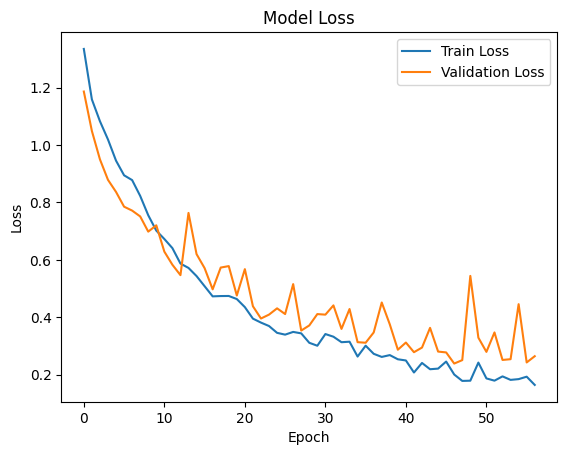

In [ ]:
# evluate the model performance on the validation set
valid_predict = model.predict(X_valid_fft) # make predictions on the validation set using the trained model

# calculate the f1-score of the validation set
f1 = f1_score(y_valid, np.round(valid_predict))
print("Validation F1-Score: ", f1)

# evaluate the model using loss and accuracy metrics on the validation set
loss, accuracy = model.evaluate(X_valid_fft, y_valid)

# visualize the training and validation loss over epochs to ensure the trained model is not overfitting
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# save the trained model
model.save("good_result_cnn_lstm_model.h5")

In [ ]:
# lastly, evaluate the trained model on the test set
test_predict = model.predict(X_test_fft) # make prediction on the test set
test_f1 = f1_score(y_test, np.round(test_predict)) # compute the f1-score
print("Test F1-Score: ", test_f1)

15/15 [==============================] - 0s 8ms/step
Test F1-Score:  0.8695652173913043


In [ ]:
# get predictions from the model
test_pred_acc = model.predict(X_test_fft)

# convert probabilities to binary predictions
test_pred_classes = (test_pred_acc > 0.5).astype("int32")

# calculate the accuracy of the test set
accuracy = accuracy_score(y_test, test_pred_classes)
print(f"Test Accuracy: {accuracy}")

15/15 [==============================] - 0s 8ms/step
Test Accuracy: 0.9340659340659341


In [ ]:
# compute the confusion matrix on the test set
cm = confusion_matrix(y_test, np.round(test_pred_acc))
print("Confusion Matrix:\n", cm)

# visualize the confusion matrix
ax= plt.subplot()
#fig, ax = plt.subplots(figsize=(8,5))
sns.set(font_scale=1.5)
sns.heatmap(cm, annot = True, fmt ='g', ax = ax, cmap = sns.cubehelix_palette(as_cmap=True));

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');